In [1]:
from xgb_results import xgb_results_regression
from split import split_data
from pprint import pprint
from utils import *
from get_data import get_uci_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x,y, description = get_uci_dataset(2) #Dataset 1 has 2 colums we need to predict...
pprint(description)

{'categorical features': [],
 'dataset name': 'AIDS Clinical Trials Group Study 175',
 'number of features': 23,
 'number of test examples': 2139,
 'number of training examples': 2139,
 'variables information':        name     role        type         demographic  \
0    pidnum       ID     Integer                None   
1       cid   Target      Binary                None   
2      time  Feature     Integer                None   
3       trt  Feature     Integer                None   
4       age  Feature     Integer                 Age   
5      wtkg  Feature  Continuous                None   
6      hemo  Feature      Binary                None   
7      homo  Feature      Binary  Sexual Orientation   
8     drugs  Feature      Binary                None   
9    karnof  Feature     Integer                None   
10   oprior  Feature      Binary                None   
11      z30  Feature      Binary                None   
12   zprior  Feature      Binary                None   
13  p

In [3]:
x_train, x_test, y_train, y_test = split_data(x, y)
x_train, x_test, y_train, y_test = convert_to_numpy_dataset(x_train, x_test, y_train, y_test)

Number of features:  23
Number of training examples:  1711
Number of test examples:  428


In [4]:
print(y_test.shape)
print(x_test.shape)
print(y_train.shape)
print(x_train.shape)

(428,)
(428, 23)
(1711,)
(1711, 23)


In [5]:
results = xgb_results_regression(x_train, x_test, y_train, y_test)
pprint(results)

metrics = ['MSE', 'R^2 Score', 'Pearson', 'Spearman']

{'Testing Metrics': {'MSE': 0.09032473560251866,
                     'Pearson': 0.7116221023900426,
                     'R^2 Score': 0.49901455274133955,
                     'Spearman': 0.607362871658546},
 'Training Metrics': {'MSE': 0.0004781508511815307,
                      'Pearson': 0.9988596827205314,
                      'R^2 Score': 0.9974183972225262,
                      'Spearman': 0.7454155672704781}}


In [6]:
guesses = get_baseline_guesses(np.concatenate((y_train, y_test)))
baseline_results = get_baseline_results(y_test, guesses)
pprint(baseline_results)

{'mean': {'MSE': 0.18035174548510868, 'R^2': -0.00031956111497111195},
 'median': {'MSE': 0.23598130841121495, 'R^2': -0.308868501529052}}


Sample Size:  10
Sample Size:  110
Sample Size:  210
Sample Size:  310
Sample Size:  410
Sample Size:  510
Sample Size:  610
Sample Size:  710
Sample Size:  810
Sample Size:  910


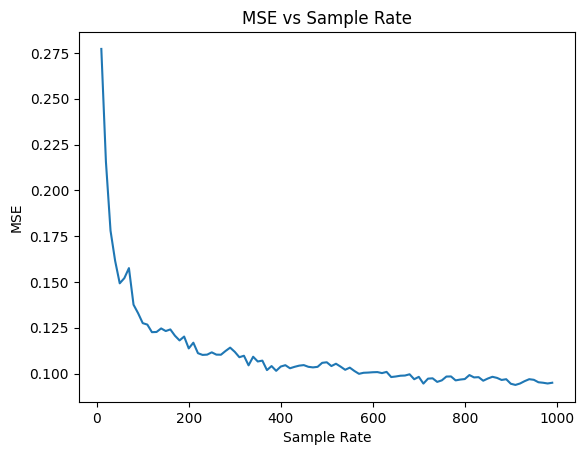

In [7]:
# sample rates are from 10 to 1000 in increments of 10
sample_sizes = np.arange(10, 1000, 10)
# create a dictionary for each metric
mse_dict = {}
mse_dict_improved = {}


for index, sample_size in enumerate(sample_sizes):
    if index % 10 == 0:
        print('Sample Size: ', sample_size)
    for i in range (10):
        x_train_sample, y_train_sample = sample_data(x_train, y_train, sample_size, seed = i)
        x_train_new_sample, y_train_new_sample, history = sample_data_improved(x_train, y_train, sample_size)
        results = xgb_results_regression(x_train_sample, x_test, y_train_sample, y_test)
        results_improved = xgb_results_regression(x_train_new_sample, x_test, y_train_new_sample, y_test)
        test_results = results['Testing Metrics']
        test_results_improved = results_improved['Testing Metrics']
        if sample_size not in mse_dict:
            mse_dict[sample_size] = [test_results['MSE']]
            mse_dict_improved[sample_size] = [test_results_improved['MSE']]
        else:
            mse_dict[sample_size].append(test_results['MSE'])
            mse_dict_improved[sample_size].append(test_results_improved['MSE'])

    mse_dict[sample_size] = np.mean(mse_dict[sample_size])
    mse_dict_improved[sample_size] = np.mean(mse_dict_improved[sample_size])



# graph mse results
plt.plot(list(mse_dict.keys()), list(mse_dict.values()))
plt.plot(list(mse_dict_improved.keys()), list(mse_dict_improved.values()))
plt.xlabel('Sample Size')
plt.ylabel('MSE')
plt.title('MSE vs Sample Size')
plt.show()

